<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/AE_MLP_Experiment_3_Generalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load in pre-made datasets
(Already normalised)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# File Paths

In [2]:
# save_path = "/Users/siancaine/Library/Mobile Documents/com~apple~CloudDocs/Honours project"
# dataset_path =  "/Users/siancaine/Library/Mobile Documents/com~apple~CloudDocs/Honours project/Datasets"

save_path = "/content/drive/MyDrive/Colab Notebooks/Honours Project/Sian's Models/AE-MLP Model"
dataset_path =  "/content/drive/MyDrive/Colab Notebooks/Honours Project/Sian's Models/AE-MLP Model"

#Imports

In [3]:

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns # Import seaborn for heatmap plotting
import numpy as np
import matplotlib.pyplot as plt

#Loads Datasets

In [4]:


# Training sets
X_train = pd.read_csv(os.path.join(dataset_path, "ae_x_train.csv")).to_numpy()
y_train = pd.read_csv(os.path.join(dataset_path, "ae_y_train.csv")).to_numpy().ravel()

# Validation sets
X_val = pd.read_csv(os.path.join(dataset_path, "ae_x_val.csv")).to_numpy()
y_val = pd.read_csv(os.path.join(dataset_path, "ae_y_val.csv")).to_numpy().ravel()

# # Classifier training sets
X_classifier_train = pd.read_csv(os.path.join(dataset_path, "adasyn_mlp_x_train.csv")).to_numpy() # MLP training data augumented using adasyn
y_classifier_train = pd.read_csv(os.path.join(dataset_path, "adasyn_mlp_y_train.csv")).to_numpy().ravel()

# Classifier validation sets
X_classifier_val = pd.read_csv(os.path.join(dataset_path, "mlp_x_val.csv")).to_numpy()
y_classifier_val = pd.read_csv(os.path.join(dataset_path, "mlp_y_val.csv")).to_numpy().ravel()

# Test sets
X_test = pd.read_csv(os.path.join(dataset_path, "ae_mlp_x_test.csv")).to_numpy()
y_test = pd.read_csv(os.path.join(dataset_path, "ae_mlp_y_test.csv")).to_numpy().ravel()

# --- Label Encoding ---
attack_type_map = {'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6} # Create a mapping from attack type to integer label



#Plot PCA graphs for visualisation

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


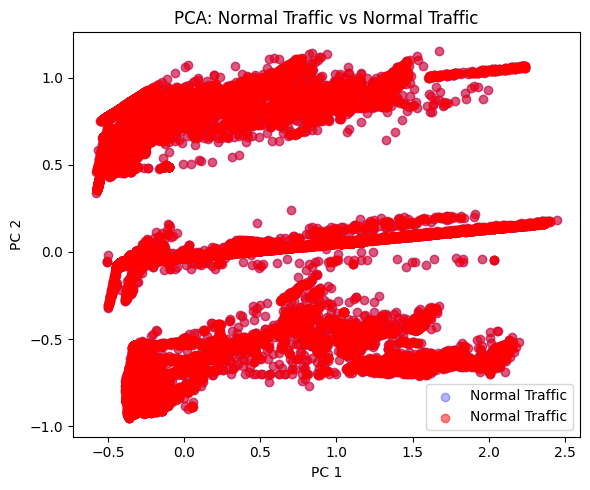

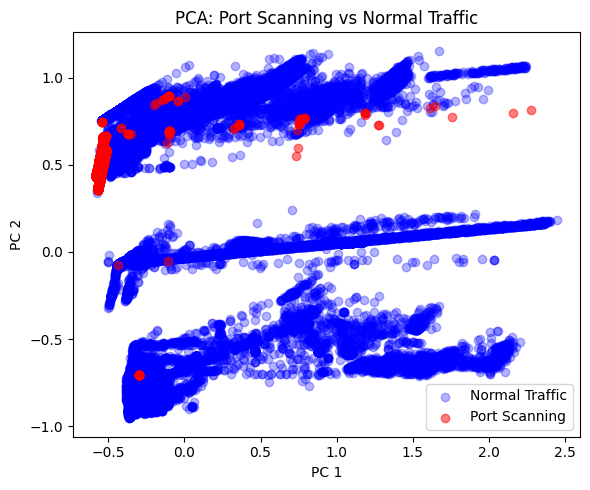

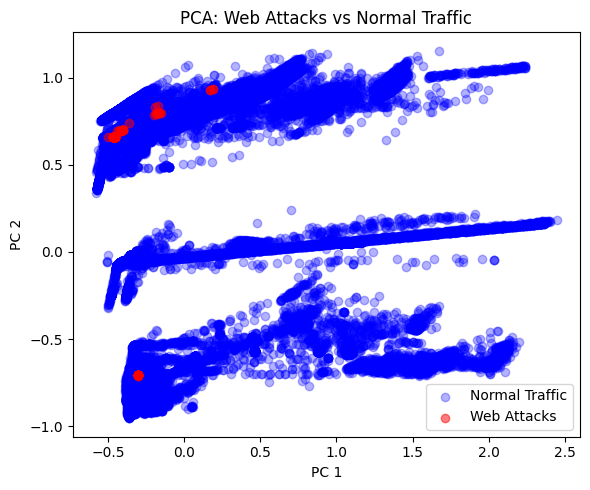

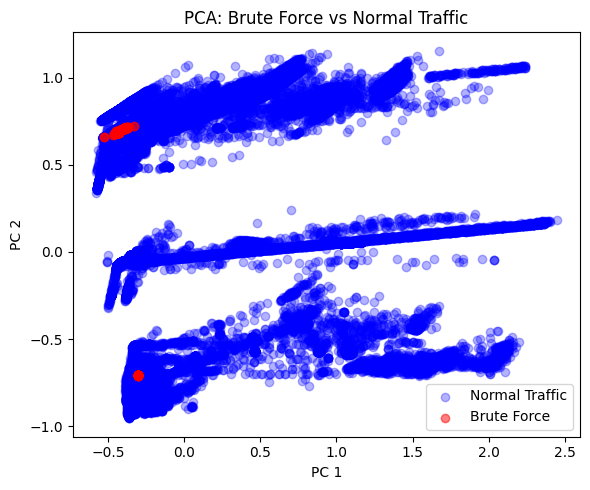

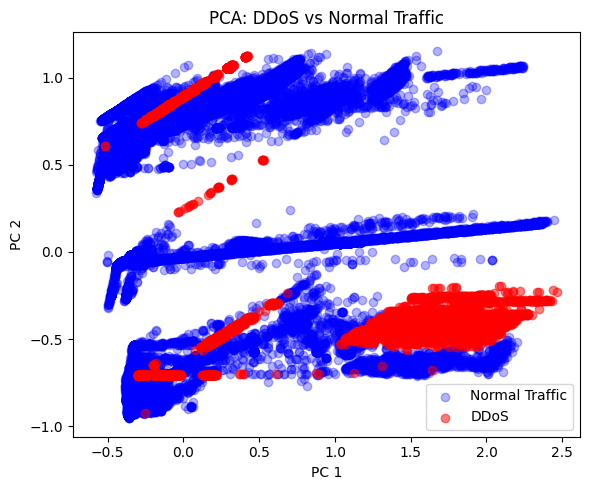

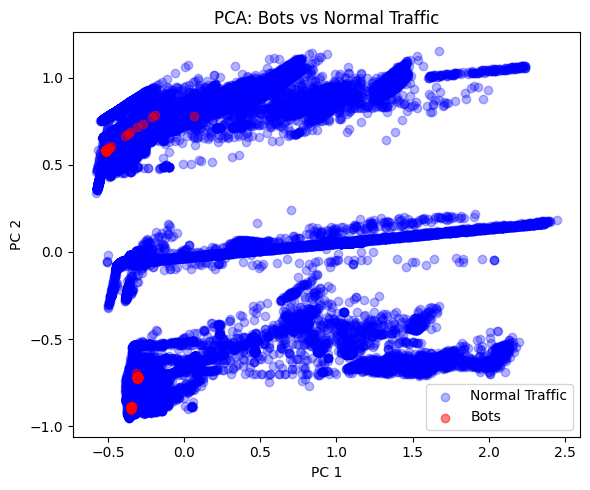

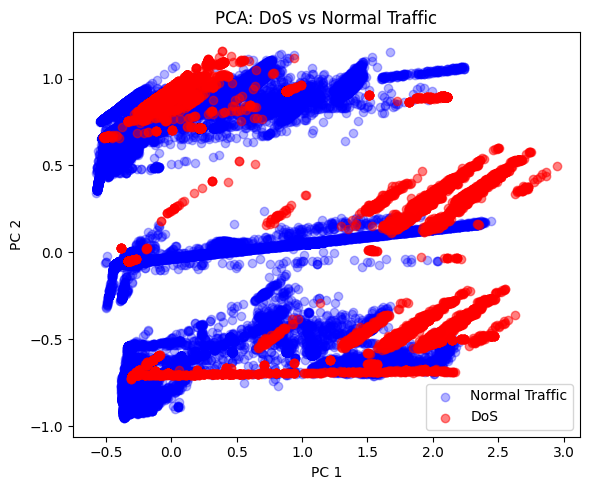

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


# Reduce dimensionality to 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

reverse_attack_type_map = {v: k for k, v in attack_type_map.items()} # Assuming attack_type_map is defined

# Loop over each attack type
for attack_label, attack_name in reverse_attack_type_map.items():
    # Mask for benign traffic
    mask_benign = y_test == 0
    # Mask for current attack
    mask_attack = y_test == attack_label

    # Plot
    plt.figure(figsize=(6,5))
    plt.scatter(X_test_pca[mask_benign, 0], X_test_pca[mask_benign, 1],
                alpha=0.3, label="Normal Traffic", color="blue")
    plt.scatter(X_test_pca[mask_attack, 0], X_test_pca[mask_attack, 1],
                alpha=0.5, label=attack_name, color="red")
    plt.title(f"PCA: {attack_name} vs Normal Traffic")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend()
    plt.tight_layout()
    plt.show()


#Remove Class Function

In [6]:
def Remove_attack_type(attack_type):
    global X_classifier_train, y_classifier_train, X_classifier_val, y_classifier_val

    # Mask for the current attack type
    # Similarly for classifier training sets
    mask_classifier_train = y_classifier_train != attack_type
    X_classifier_train_filtered = X_classifier_train[mask_classifier_train]
    y_classifier_train_filtered = y_classifier_train[mask_classifier_train]

    # Classifier validation sets
    mask_classifier_val = y_classifier_val != attack_type
    X_classifier_val_filtered = X_classifier_val[mask_classifier_val]
    y_classifier_val_filtered = y_classifier_val[mask_classifier_val]

    return X_classifier_train_filtered, y_classifier_train_filtered, X_classifier_val_filtered, y_classifier_val_filtered


#Import AE

In [7]:
def get_ae():
  # -------------------------
  # --- Load AE Model ---
  # -------------------------
  ae_model_path = os.path.join(save_path, 'Best_AE.keras')

  ae_model = load_model(ae_model_path)

  # -----------------------------------
  # --- Load Per-Feature Thresholds ---
  # -----------------------------------
  per_feature_thresholds_path = os.path.join(save_path, 'ae_per_feature_thresholds.npy')
  per_feature_thresholds = np.load(per_feature_thresholds_path)

  return ae_model, per_feature_thresholds


# Build MLP Model Function

In [8]:
def build_mlp():
  global X_classifier_train, y_classifier_train
  # Input dimensions
  input_dim = X_classifier_train.shape[1]  # e.g., encoder output size
  num_classes = len(np.unique(y_classifier_train))

  # Define the model
  classifier = Sequential([
          Input(shape=(input_dim,)),
          # Input layer with L2 regularization
          Dense(64,
                activation='relu',
                kernel_regularizer=l2(0.001)),

          # Hidden layer
          Dense(32,
                activation='relu',
                kernel_regularizer=l2(0.001)),

          Dropout(0.2),

          # Output layer
          Dense(num_classes,
                activation='softmax')
      ])

  # Compile the model with custom learning rate
  classifier.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  print(classifier.summary())

  return classifier

# Train MLP Function

In [9]:
# --- Train the MLP Classifer Model ---

def train_mlp(classifier, new_X_classifier_train, new_y_classifier_train,new_X_classifier_val, new_y_classifier_val): # Train the model

  early_stopping = EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                                patience=4, #the number of epochs to wait for an improvement
                                restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

  # Train the model
  history = classifier.fit(
      new_X_classifier_train, new_y_classifier_train,
      epochs=20,
      batch_size=64,
      validation_data=(new_X_classifier_val, new_y_classifier_val),
      verbose=1,
      callbacks=[early_stopping], # Add early stopping callback
  )

  # --- Plot history accuracy and loss graphs ---
  plt.figure(figsize=(12,5)) # Create a new figure that is 12x5

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Acc') # Corrected key
  plt.plot(history.history['val_accuracy'], label='Val Acc') # Corrected key
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()



  return classifier # Return the trained classifier

# Test the models on the test dataset

In [10]:

def test_models(autoencoder, per_feature_thresholds, classifier):
  global X_test, y_test
  test_reconstructions = autoencoder.predict(X_test, verbose=1)# Run autoencoder on the entire test set at once

  test_reconstruction_errors = np.abs(test_reconstructions - X_test)# Compute reconstruction errors for all samples

  AE_y_pred = (test_reconstruction_errors > per_feature_thresholds).any(axis=1).astype(int)# Flag anomalies (ANY feature above its threshold per sample) and broadcast thresholds across all samples

  malicious_pred_indices = np.flatnonzero(AE_y_pred)# Find the indices of all non-zero elements in AE_y_pred (samples predicted as Malicious)


  # Run classifier only on anomalous samples (if any)
  classifier_y_pred_probs, classifier_y_preds, classifier_y_test, classifier_x_test = [], [], [], []

  if len(malicious_pred_indices) > 0:
      classifier_y_test = y_test[malicious_pred_indices]
      classifier_x_test = X_test[malicious_pred_indices]

      classifier_y_pred_probs = classifier.predict(classifier_x_test, verbose=1)
      classifier_y_preds = np.argmax(classifier_y_pred_probs, axis=1)

  return AE_y_pred, classifier_y_preds, classifier_y_test, classifier_x_test



# Evaluate AE Predictions Against Ground Truths

In [11]:

def evaluate_ae(AE_y_pred, unseen_attack):
  global y_test

  reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
  unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

  y_test_binary = (y_test != 0).astype(int)# Convert y_test to binary: 0 = Normal, 1 = Anomaly

  # --- Confusion matrix ---
  ae_cm = confusion_matrix(y_test_binary, AE_y_pred)
  ae_tn, ae_fp, ae_fn, ae_tp = ae_cm.ravel() # Unpack confusion matrix values

  # Plot heatmap
  plt.figure(figsize=(4, 2)) # Adjust figure size
  # Labels for the binary confusion matrix
  binary_labels = ['Benign', 'Anomaly']
  sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=binary_labels, yticklabels=binary_labels)
  plt.title("AE Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

  print("\nAE Metrics:")
  print(f"True Positives (Anomalies correctly detected): {ae_tp}")
  print(f"True Negatives (Normal Traffic correctly identified): {ae_tn}")
  print(f"False Positives (Normal Traffic misclassified as Anomaly): {ae_fp}")
  print(f"False Negatives (Anomalies missed): {ae_fn}\n")
  accuracy = (ae_tp + ae_tn) / (ae_tp + ae_tn + ae_fp + ae_fn) if (ae_tp + ae_tn + ae_fp + ae_fn) > 0 else 0
  precision = ae_tp / (ae_tp + ae_fp) if (ae_tp + ae_fp) > 0 else 0
  recall = ae_tp / (ae_tp + ae_fn) if (ae_tp + ae_fn) > 0 else 0
  f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  false_positive_rate = ae_fp / (ae_fp + ae_tn) if (ae_fp + ae_tn) > 0 else 0
  false_negative_rate = ae_fn / (ae_fn + ae_tp) if (ae_fn + ae_tp) > 0 else 0

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print(f"False Positive Rate (FPR): {false_positive_rate:.4f}")
  print(f"False Negative Rate (FNR): {false_negative_rate:.4f}")

  unseen_attack_test_indices = np.where(y_test == unseen_attack)[0]# Get indices of DoS samples in the original test set
  mal_unseen_attack = np.sum(AE_y_pred[unseen_attack_test_indices] == 1)# Count how many were predicted as malicious by the AE
  benign_unseen_attack = np.sum(AE_y_pred[unseen_attack_test_indices] == 0)# Count how many were predicted as benign by the AE
  print(f"Total number of {unseen_attack_label} samples classified as malicious by AE: {mal_unseen_attack}")
  print(f"Total number of {unseen_attack_label} samples classified as benign by AE: {benign_unseen_attack}")


# Evaluate MLP Classifier Predictions

In [12]:
def evaluate_classifier(classifier_y_test, classifier_y_preds, unseen_attack):
    # --- Confusion matrix ---
    mlp_cm = confusion_matrix(classifier_y_test, classifier_y_preds)

    # Get the original attack type names from the mapping
    reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
    labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(mlp_cm.shape[0])] # Use matrix shape for label count
    unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

    # Plot heatmap
    plt.figure(figsize=(7, 4))
    sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Classifier Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # --- Custom Metrics for Malware vs Benign (Normal Traffic) ---
    normal_traffic = attack_type_map.get('Normal Traffic', None)
    if normal_traffic is not None:

        total_benign = np.sum(mlp_cm[normal_traffic, :])
        benign_identified_correctly = mlp_cm[normal_traffic, normal_traffic] #TN
        benign_misclassified =  total_benign - benign_identified_correctly #FP

        mlp_tn = benign_identified_correctly
        mlp_fp = benign_misclassified

        total_malware = np.sum(mlp_cm) - np.sum(mlp_cm[normal_traffic, :])

        # Count all malware samples correctly identified (diagonal elements excluding normal traffic)
        malware_identified_correctly = np.sum(np.diag(mlp_cm)) - mlp_cm[normal_traffic, normal_traffic]

        # Count all the malware samples identified even if misclassified as the wrong type of malware
        total_malware_identified = 0
        for i in range(len(labels)):
            if i != normal_traffic:  # skip the normal traffic row in the cm
                # for a row/class in the cm, count the samples from malware class that were predicted as ANY malware type (not benign)
                malware_predicted_as_any_malware = np.sum(mlp_cm[i, :]) - mlp_cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                total_malware_identified += malware_predicted_as_any_malware

        malware_misclassified = total_malware - total_malware_identified

        mlp_fn = malware_misclassified
        mlp_tp = total_malware_identified

        print(f"Total Malware Samples: {total_malware}")
        print(f"Total Benign Samples: {total_benign}")

        # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
            # TP: Malware identified as ANY malware type (total_malware_identified_as_malware)
            # TN: Benign correctly predicted as Benign (cm[normal_traffic_label, normal_traffic_label])
            # FP: Benign incorrectly predicted as Malware (benign_misclassified_as_malware_count)
            # FN: Malware incorrectly predicted as Benign (Total Malware Samples - Malware Identified as Any Malware)

        print("\nTP, TN, FP, FN for Malware vs Benign:")

        print(f"True Positives (Malware predicted as ANY malware): {mlp_tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
        print(f"True Negatives (Benign predicted as Benign): {mlp_tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
        print(f"False Positives (Benign predicted as Malware): {mlp_fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
        print(f"False Negatives (Malware predicted as Benign): {mlp_fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

        print("\nPercentage of each Malware Class Correctly Identified:")
        for i, label in enumerate(labels):
            if i != normal_traffic: # Exclude 'Normal Traffic'
                correctly_identified = mlp_cm[i, i]
                total_in_class = np.sum(mlp_cm[i, :])
                percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                print(f"{label}: {percentage_identified:.2f}%")

        # ---- Performance Metrics ---
        # Accuracy
        accuracy = (mlp_tp + mlp_tn) / (mlp_tp + mlp_tn + mlp_fp + mlp_fn) if (mlp_tp + mlp_tn + mlp_fp + mlp_fn) > 0 else 0
        # Precision (for malware class)
        precision = mlp_tp / (mlp_tp + mlp_fp) if (mlp_tp + mlp_fp) > 0 else 0
        # Recall / Sensitivity (for malware class)
        recall = mlp_tp / (mlp_tp + mlp_fn) if (mlp_tp + mlp_fn) > 0 else 0
        # F1-Score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        # False Positive Rate (FPR)
        fpr = (mlp_fp / (mlp_fp + mlp_tn)) * 100 if (mlp_fp + mlp_tn) > 0 else 0
        # False Negative Rate (FNR)
        fnr = (mlp_fn / (mlp_fn + mlp_tp)) * 100 if (mlp_fn + mlp_tp) > 0 else 0

        print("\n--- Malware vs Benign Performance Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Malware): {precision:.4f}")
        print(f"Recall / Sensitivity (Malware): {recall:.4f}")
        print(f"F1-Score (Malware): {f1_score:.4f}")
        print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
        print(f"False Negative Rate (Malware missed): {fnr:.2f}%")


        unseen_attack_test_indices = np.where(classifier_y_test == unseen_attack)[0]
        mal_unseen_attack = np.sum(classifier_y_preds[unseen_attack_test_indices] == unseen_attack)
        benign_unseen_attack = np.sum(classifier_y_preds[unseen_attack_test_indices] == 0)

        print(f"Total number of {unseen_attack_label} samples classified as malicious by MLP: {mal_unseen_attack}")
        print(f"Total number of {unseen_attack_label} samples classified as benign by MLP: {benign_unseen_attack}")


#Quant Models

In [13]:
import tensorflow as tf

def mlp_representative_dataset_gen(y_classifier_train, X_classifier_train):
    # Get class distribution
    class_types, class_counts = np.unique(y_classifier_train, return_counts=True)
    min_samples_per_class = min(class_counts)

    class_indices = [np.where(y_classifier_train == c)[0] for c in class_types]

    # Pick equal number of samples per class (e.g., 100 per class)
    selected_indices = []
    rng = np.random.default_rng(seed=123)
    for indices in class_indices:

        selected_indices.extend(rng.choice(indices, 100, replace=False))

    np.random.shuffle(selected_indices)
    representative_indices = selected_indices

    # Yield samples reshaped for MLP: (1, feature_dim)
    for i in representative_indices:
        yield [X_classifier_train[i].astype(np.float32).reshape(1, -1)]


def quant_models(autoencoder, classifier, y_classifier_train, X_classifier_train):
    # --- Load AE Quant Models (with TFLite Interpreter) ---
    ae_model_base = os.path.join(save_path,'Best_AE')
    ae_quantModel_f32 = tf.lite.Interpreter(model_path=ae_model_base + '_float32.tflite')
    ae_quantModel_int8_weights = tf.lite.Interpreter(model_path=ae_model_base + '_int8_weights.tflite')
    ae_quantModel_fp16_weights = tf.lite.Interpreter(model_path=ae_model_base + '_fp16_weights.tflite')
    ae_quantModel_full_int8 = tf.lite.Interpreter(model_path=ae_model_base + '_int8_full.tflite')

    # QUANT MLPS
    # --- Float32 baseline (no quantization) ---
    converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
    print("# --- MLP Float32 baseline (no quantization) ---")
    mlp_quantModel_f32 = converter.convert()
    mlp_quantModel_f32 = tf.lite.Interpreter(model_content=mlp_quantModel_f32)

    # --- Weight-only quantization (float16 weights, float32 activations) ---
    converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    print("# --- MLP Weight-only quantization (float16 weights, float32 activations) ---")
    mlp_quantModel_fp16_weights = converter.convert()
    mlp_quantModel_fp16_weights = tf.lite.Interpreter(model_content=mlp_quantModel_fp16_weights)

    # --- Weight-only quantization (int8 weights, float32 activations) ---
    converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    print("# --- MLP Weight-only quantization (int8 weights, float32 activations) ---")
    mlp_quantModel_int8_weights = converter.convert()
    mlp_quantModel_int8_weights = tf.lite.Interpreter(model_content=mlp_quantModel_int8_weights)

    # --- MLP Full 8-bit Integer Quantization ---
    converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = lambda: mlp_representative_dataset_gen(y_classifier_train, X_classifier_train)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    print("# --- MLP Full 8-bit Integer Quantization ---")
    mlp_quantModel_full_int8 = converter.convert()
    mlp_quantModel_full_int8 = tf.lite.Interpreter(model_content=mlp_quantModel_full_int8)

    print("Quant Models Ready!")

    return (
        ae_quantModel_f32, ae_quantModel_int8_weights, ae_quantModel_fp16_weights, ae_quantModel_full_int8,
        mlp_quantModel_f32, mlp_quantModel_fp16_weights, mlp_quantModel_int8_weights, mlp_quantModel_full_int8
    )


#Evaluate Quant Models

In [14]:
# --- Evaluate all AE → MLP TFLite models ---
def evaluate_weight_quant_model(tflite_weight_models, per_feature_thresholds, unseen_attack):
    global X_test, y_test

    for m in tflite_weight_models:
        ae_model_content = m["ae_model"]
        ae_name = m["ae_name"]

        mlp_model_content = m["mlp_model"]
        mlp_name = m["mlp_name"]

        print(f"\n --- Evaluating AE: {ae_name} → MLP: {mlp_name} ---")

        # -------------------
        # --- Autoencoder ---
        # -------------------

        ae_interpreter = ae_model_content
        ae_interpreter.allocate_tensors()
        ae_input_details = ae_interpreter.get_input_details()
        ae_output_details = ae_interpreter.get_output_details()

        # Get AE predictions
        ae_y_pred_probs = []
        for i in range(len(X_test)):
            input_data = np.expand_dims(X_test[i], axis=0).astype(ae_input_details[0]['dtype'])
            ae_interpreter.set_tensor(ae_input_details[0]['index'], input_data)
            ae_interpreter.invoke()
            ae_output_data = ae_interpreter.get_tensor(ae_output_details[0]['index'])
            ae_y_pred_probs.append(ae_output_data[0])

        ae_y_pred_probs = np.array(ae_y_pred_probs)
        test_reconstruction_errors = np.abs(ae_y_pred_probs - X_test)
        ae_y_pred = (test_reconstruction_errors > per_feature_thresholds).any(axis=1).astype(int)

        malicious_pred_indices = np.flatnonzero(ae_y_pred)

        # Confusion matrix for AE
        y_test_binary = (y_test != 0).astype(int)
        ae_cm = confusion_matrix(y_test_binary, ae_y_pred)

        plt.figure(figsize=(6, 4))
        sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Malware"], yticklabels=["Normal", "Malware"])
        plt.title(f"{ae_name} - Confusion Matrix (Anomaly Detection)")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        ae_tn, ae_fp, ae_fn, ae_tp = ae_cm.ravel()

        print("\nQuant AE Metrics:")
        print(f"True Positives (Anomalies correctly detected): {ae_tp}")
        print(f"True Negatives (Normal Traffic correctly identified): {ae_tn}")
        print(f"False Positives (Normal Traffic misclassified as Anomaly): {ae_fp}")
        print(f"False Negatives (Anomalies missed): {ae_fn}\n")
        accuracy = (ae_tp + ae_tn) / (ae_tp + ae_tn + ae_fp + ae_fn) if (ae_tp + ae_tn + ae_fp + ae_fn) > 0 else 0
        precision = ae_tp / (ae_tp + ae_fp) if (ae_tp + ae_fp) > 0 else 0
        recall = ae_tp / (ae_tp + ae_fn) if (ae_tp + ae_fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        false_positive_rate = ae_fp / (ae_fp + ae_tn) if (ae_fp + ae_tn) > 0 else 0
        false_negative_rate = ae_fn / (ae_fn + ae_tp) if (ae_fn + ae_tp) > 0 else 0

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"False Positive Rate (FPR): {false_positive_rate:.4f}")
        print(f"False Negative Rate (FNR): {false_negative_rate:.4f}")

        reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
        unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

        unseen_attack_test_indices = np.where(y_test == unseen_attack)[0]
        mal_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 1)
        benign_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 0)

        print(f"Total number of {unseen_attack_label} samples classified as malicious by AE: {mal_unseen_attack}")
        print(f"Total number of {unseen_attack_label} samples classified as benign by AE: {benign_unseen_attack}")

        # -------------------
        # --- MLP ---
        # -------------------

        mlp_interpreter = mlp_model_content
        mlp_interpreter.allocate_tensors()
        mlp_input_details = mlp_interpreter.get_input_details()
        mlp_output_details = mlp_interpreter.get_output_details()

        # Get MLP predictions
        mlp_y_pred_probs = []
        mlp_X_test = X_test[malicious_pred_indices]
        mlp_y_test = y_test[malicious_pred_indices]

        for i in range(len(mlp_X_test)):
            input_data = np.expand_dims(mlp_X_test[i], axis=0).astype(mlp_input_details[0]['dtype'])
            mlp_interpreter.set_tensor(mlp_input_details[0]['index'], input_data)
            mlp_interpreter.invoke()
            mlp_output_data = mlp_interpreter.get_tensor(mlp_output_details[0]['index'])
            mlp_y_pred_probs.append(mlp_output_data[0])

        mlp_y_pred_probs = np.array(mlp_y_pred_probs)
        mlp_y_pred = np.argmax(mlp_y_pred_probs, axis=1)

        # Confusion matrix for MLP
        mlp_cm = confusion_matrix(mlp_y_test, mlp_y_pred)
        labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(mlp_cm.shape[0])]
        # Plot heatmap
        plt.figure(figsize=(7, 4))
        sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.title("Classifier Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        normal_traffic = attack_type_map.get('Normal Traffic', None)

        if normal_traffic is not None:

            total_benign = np.sum(mlp_cm[normal_traffic, :])
            benign_identified_correctly = mlp_cm[normal_traffic, normal_traffic] #TN
            benign_misclassified =  total_benign - benign_identified_correctly #FP

            mlp_tn = benign_identified_correctly
            mlp_fp = benign_misclassified

            total_malware = np.sum(mlp_cm) - np.sum(mlp_cm[normal_traffic, :])

            # Count all malware samples correctly identified (diagonal elements excluding normal traffic)
            malware_identified_correctly = np.sum(np.diag(mlp_cm)) - mlp_cm[normal_traffic, normal_traffic]

            # Count all the malware samples identified even if misclassified as the wrong type of malware
            total_malware_identified = 0
            for i in range(len(labels)):
                if i != normal_traffic:  # skip the normal traffic row in the cm
                    # for a row/class in the cm, count the samples from malware class that were predicted as ANY malware type (not benign)
                    malware_predicted_as_any_malware = np.sum(mlp_cm[i, :]) - mlp_cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                    total_malware_identified += malware_predicted_as_any_malware

            malware_misclassified = total_malware - total_malware_identified

            mlp_fn = malware_misclassified
            mlp_tp = total_malware_identified

            print(f"Total Malware Samples: {total_malware}")
            print(f"Total Benign Samples: {total_benign}")

            # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
                # TP: Malware identified as ANY malware type (total_malware_identified_as_malware)
                # TN: Benign correctly predicted as Benign (cm[normal_traffic_label, normal_traffic_label])
                # FP: Benign incorrectly predicted as Malware (benign_misclassified_as_malware_count)
                # FN: Malware incorrectly predicted as Benign (Total Malware Samples - Malware Identified as Any Malware)

            print("\nTP, TN, FP, FN for Malware vs Benign:")

            print(f"True Positives (Malware predicted as ANY malware): {mlp_tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
            print(f"True Negatives (Benign predicted as Benign): {mlp_tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
            print(f"False Positives (Benign predicted as Malware): {mlp_fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
            print(f"False Negatives (Malware predicted as Benign): {mlp_fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

            print("\nPercentage of each Malware Class Correctly Identified:")
            for i, label in enumerate(labels):
                if i != normal_traffic: # Exclude 'Normal Traffic'
                    correctly_identified = mlp_cm[i, i]
                    total_in_class = np.sum(mlp_cm[i, :])
                    percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                    print(f"{label}: {percentage_identified:.2f}%")

            # ---- Performance Metrics ---
            # Accuracy
            accuracy = (mlp_tp + mlp_tn) / (mlp_tp + mlp_tn + mlp_fp + mlp_fn) if (mlp_tp + mlp_tn + mlp_fp + mlp_fn) > 0 else 0
            # Precision (for malware class)
            precision = mlp_tp / (mlp_tp + mlp_fp) if (mlp_tp + mlp_fp) > 0 else 0
            # Recall / Sensitivity (for malware class)
            recall = mlp_tp / (mlp_tp + mlp_fn) if (mlp_tp + mlp_fn) > 0 else 0
            # F1-Score
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            # False Positive Rate (FPR)
            fpr = (mlp_fp / (mlp_fp + mlp_tn)) * 100 if (mlp_fp + mlp_tn) > 0 else 0
            # False Negative Rate (FNR)
            fnr = (mlp_fn / (mlp_fn + mlp_tp)) * 100 if (mlp_fn + mlp_tp) > 0 else 0

            print("\n--- Malware vs Benign Performance Metrics ---")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision (Malware): {precision:.4f}")
            print(f"Recall / Sensitivity (Malware): {recall:.4f}")
            print(f"F1-Score (Malware): {f1_score:.4f}")
            print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
            print(f"False Negative Rate (Malware missed): {fnr:.2f}%")

            unseen_attack_test_indices = np.where(mlp_y_test == unseen_attack)[0]
            mal_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == unseen_attack)
            benign_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == 0)

            print(f"Total number of {unseen_attack_label} samples classified as malicious by MLP: {mal_unseen_attack}")
            print(f"Total number of {unseen_attack_label} samples classified as benign by MLP: {benign_unseen_attack}")


In [15]:
def evaluate_full_int8_quant_model(tflite_full_int_models, unseen_attack):
    global X_test, y_test

    # --- Evaluate all AE → MLP TFLite models ---
    for m in tflite_full_int_models:
        # --- Unpack model info ---
        ae_model_content = m["ae_model"]
        ae_name = m["ae_name"]

        mlp_model_content = m["mlp_model"]
        mlp_name = m["mlp_name"]

        print(f"\n--- Evaluating AE: {ae_name} → MLP: {mlp_name} ---")

        # -------------
        # ---- AE -----
        # -------------
        ae_interpreter = ae_model_content
        ae_interpreter.allocate_tensors()
        ae_input_details = ae_interpreter.get_input_details()[0]
        ae_output_details = ae_interpreter.get_output_details()[0]

        in_scale,  in_zp  = ae_input_details['quantization']
        out_scale, out_zp = ae_output_details['quantization']

        # --- Load thresholds for quantized model ---
        full_int8_per_feature_thresholds_path = os.path.join(save_path,'FULL_INT8_per_feature_Threshold.npy')
        full_int8_per_feature_thresholds = np.load(full_int8_per_feature_thresholds_path)

        # --- AE Predictions ---
        ae_y_pred_probs = []
        for i in range(len(X_test)):
            x = np.expand_dims(X_test[i].astype(np.float32), axis=0)  # shape [1, num_features]
            if ae_input_details['dtype'] == np.int8:
                xq = np.round(x / in_scale + in_zp).astype(np.int8)
            else:
                xq = x.astype(ae_input_details['dtype'])

            ae_interpreter.set_tensor(ae_input_details['index'], xq)
            ae_interpreter.invoke()
            yq = ae_interpreter.get_tensor(ae_output_details['index'])

            if ae_output_details['dtype'] == np.int8:
                y = (yq.astype(np.float32) - out_zp) * out_scale
            else:
                y = yq.astype(np.float32)

            ae_y_pred_probs.append(y[0])

        ae_y_pred_probs = np.array(ae_y_pred_probs)

        # --- Anomaly Detection ---
        test_reconstruction_errors = np.abs(ae_y_pred_probs - X_test)
        ae_y_pred = (test_reconstruction_errors > full_int8_per_feature_thresholds).any(axis=1).astype(int)
        malicious_pred_indices = np.flatnonzero(ae_y_pred)

        # --- Confusion Matrix (AE) ---
        reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
        unseen_attack_label = reverse_attack_type_map.get(unseen_attack, f"Unknown {unseen_attack}")

        y_test_binary = (y_test != 0).astype(int)  # Convert y_test to binary: 0 = Normal, 1 = Anomaly
        ae_cm = confusion_matrix(y_test_binary, ae_y_pred)
        ae_tn, ae_fp, ae_fn, ae_tp = ae_cm.ravel()

        # Plot heatmap
        plt.figure(figsize=(4, 2))
        sns.heatmap(ae_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Anomaly'], yticklabels=['Benign', 'Anomaly'])
        plt.title("AE Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        print("\nQuant AE Metrics:")
        print(f"True Positives (Anomalies correctly detected): {ae_tp}")
        print(f"True Negatives (Normal Traffic correctly identified): {ae_tn}")
        print(f"False Positives (Normal Traffic misclassified as Anomaly): {ae_fp}")
        print(f"False Negatives (Anomalies missed): {ae_fn}\n")
        accuracy = (ae_tp + ae_tn) / (ae_tp + ae_tn + ae_fp + ae_fn) if (ae_tp + ae_tn + ae_fp + ae_fn) > 0 else 0
        precision = ae_tp / (ae_tp + ae_fp) if (ae_tp + ae_fp) > 0 else 0
        recall = ae_tp / (ae_tp + ae_fn) if (ae_tp + ae_fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        false_positive_rate = ae_fp / (ae_fp + ae_tn) if (ae_fp + ae_tn) > 0 else 0
        false_negative_rate = ae_fn / (ae_fn + ae_tp) if (ae_fn + ae_tp) > 0 else 0

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"False Positive Rate (FPR): {false_positive_rate:.4f}")
        print(f"False Negative Rate (FNR): {false_negative_rate:.4f}")

        unseen_attack_test_indices = np.where(y_test == unseen_attack)[0]
        mal_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 1)
        benign_unseen_attack = np.sum(ae_y_pred[unseen_attack_test_indices] == 0)
        print(f"Total number of {unseen_attack_label} samples classified as malicious by AE: {mal_unseen_attack}")
        print(f"Total number of {unseen_attack_label} samples classified as benign by AE: {benign_unseen_attack}")

        # -------------
        # --- MLP -----
        # -------------
        mlp_interpreter = mlp_model_content
        mlp_interpreter.allocate_tensors()
        mlp_input_details = mlp_interpreter.get_input_details()[0]
        mlp_output_details = mlp_interpreter.get_output_details()[0]

        mlp_in_scale, mlp_in_zp = mlp_input_details['quantization']
        mlp_out_scale, mlp_out_zp = mlp_output_details['quantization']

        # --- MLP Predictions ---
        mlp_y_pred_probs = []
        mlp_X_test = X_test[malicious_pred_indices]
        mlp_y_test = y_test[malicious_pred_indices]

        for i in range(len(mlp_X_test)):
            x = np.expand_dims(mlp_X_test[i].astype(np.float32), axis=0)
            if mlp_input_details['dtype'] == np.int8:
                xq = np.round(x / mlp_in_scale + mlp_in_zp).astype(np.int8)
            else:
                xq = x.astype(mlp_input_details['dtype'])

            mlp_interpreter.set_tensor(mlp_input_details['index'], xq)
            mlp_interpreter.invoke()
            yq = mlp_interpreter.get_tensor(mlp_output_details['index'])

            if mlp_output_details['dtype'] == np.int8:
                y = (yq.astype(np.float32) - mlp_out_zp) * mlp_out_scale
            else:
                y = yq.astype(np.float32)

            mlp_y_pred_probs.append(y[0])

        mlp_y_pred_probs = np.array(mlp_y_pred_probs)
        mlp_y_pred = np.argmax(mlp_y_pred_probs, axis=1)

        # --- Confusion Matrix (MLP) ---
        mlp_cm = confusion_matrix(mlp_y_test, mlp_y_pred)
        labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(mlp_cm.shape[0])]

        # Plot heatmap
        plt.figure(figsize=(7, 4))
        sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
        plt.title("Classifier Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        normal_traffic = attack_type_map.get('Normal Traffic', None)

        if normal_traffic is not None:

            total_benign = np.sum(mlp_cm[normal_traffic, :])
            benign_identified_correctly = mlp_cm[normal_traffic, normal_traffic] #TN
            benign_misclassified =  total_benign - benign_identified_correctly #FP

            mlp_tn = benign_identified_correctly
            mlp_fp = benign_misclassified

            total_malware = np.sum(mlp_cm) - np.sum(mlp_cm[normal_traffic, :])

            # Count all malware samples correctly identified (diagonal elements excluding normal traffic)
            malware_identified_correctly = np.sum(np.diag(mlp_cm)) - mlp_cm[normal_traffic, normal_traffic]

            # Count all the malware samples identified even if misclassified as the wrong type of malware
            total_malware_identified = 0
            for i in range(len(labels)):
                if i != normal_traffic:  # skip the normal traffic row in the cm
                    # for a row/class in the cm, count the samples from malware class that were predicted as ANY malware type (not benign)
                    malware_predicted_as_any_malware = np.sum(mlp_cm[i, :]) - mlp_cm[i, 0] # Count all the samples in the row, minus the column of samples predicted as normal traffic
                    total_malware_identified += malware_predicted_as_any_malware

            malware_misclassified = total_malware - total_malware_identified

            mlp_fn = malware_misclassified
            mlp_tp = total_malware_identified

            print(f"Total Malware Samples: {total_malware}")
            print(f"Total Benign Samples: {total_benign}")

            # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
                # TP: Malware identified as ANY malware type (total_malware_identified_as_malware)
                # TN: Benign correctly predicted as Benign (cm[normal_traffic_label, normal_traffic_label])
                # FP: Benign incorrectly predicted as Malware (benign_misclassified_as_malware_count)
                # FN: Malware incorrectly predicted as Benign (Total Malware Samples - Malware Identified as Any Malware)

            print("\nTP, TN, FP, FN for Malware vs Benign:")

            print(f"True Positives (Malware predicted as ANY malware): {mlp_tp} ({(total_malware_identified/total_malware)*100:.2f}% of Malware Identified)")
            print(f"True Negatives (Benign predicted as Benign): {mlp_tn} ({(benign_identified_correctly/total_benign)*100:.2f}% of Benign Identified)")
            print(f"False Positives (Benign predicted as Malware): {mlp_fp} ({(benign_misclassified/total_benign)*100:.2f}% of Benign Misclassified)")
            print(f"False Negatives (Malware predicted as Benign): {mlp_fn} ({(malware_misclassified/total_malware)*100:.2f}% of Malware Misclassified)")

            print("\nPercentage of each Malware Class Correctly Identified:")
            for i, label in enumerate(labels):
                if i != normal_traffic: # Exclude 'Normal Traffic'
                    correctly_identified = mlp_cm[i, i]
                    total_in_class = np.sum(mlp_cm[i, :])
                    percentage_identified = (correctly_identified / total_in_class) * 100 if total_in_class > 0 else 0
                    print(f"{label}: {percentage_identified:.2f}%")

            # ---- Performance Metrics ---
            # Accuracy
            accuracy = (mlp_tp + mlp_tn) / (mlp_tp + mlp_tn + mlp_fp + mlp_fn) if (mlp_tp + mlp_tn + mlp_fp + mlp_fn) > 0 else 0
            # Precision (for malware class)
            precision = mlp_tp / (mlp_tp + mlp_fp) if (mlp_tp + mlp_fp) > 0 else 0
            # Recall / Sensitivity (for malware class)
            recall = mlp_tp / (mlp_tp + mlp_fn) if (mlp_tp + mlp_fn) > 0 else 0
            # F1-Score
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            # False Positive Rate (FPR)
            fpr = (mlp_fp / (mlp_fp + mlp_tn)) * 100 if (mlp_fp + mlp_tn) > 0 else 0
            # False Negative Rate (FNR)
            fnr = (mlp_fn / (mlp_fn + mlp_tp)) * 100 if (mlp_fn + mlp_tp) > 0 else 0

            print("\n--- Malware vs Benign Performance Metrics ---")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision (Malware): {precision:.4f}")
            print(f"Recall / Sensitivity (Malware): {recall:.4f}")
            print(f"F1-Score (Malware): {f1_score:.4f}")
            print(f"False Positive Rate (Benign misclassified): {fpr:.2f}%")
            print(f"False Negative Rate (Malware missed): {fnr:.2f}%")

            unseen_attack_test_indices = np.where(mlp_y_test == unseen_attack)[0]
            mal_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == unseen_attack)
            benign_unseen_attack = np.sum(mlp_y_pred[unseen_attack_test_indices] == 0)
            print(f"Total number of {unseen_attack_label} samples classified as malicious by MLP: {mal_unseen_attack}")
            print(f"Total number of {unseen_attack_label} samples classified as benign by MLP: {benign_unseen_attack}")


#REMOVING DoS

In [16]:
# # Removing DoS
# dos_encoding = 6

# # --- Get filtered datasets ---
# X_classifier_train_no_DoS, y_classifier_train_no_DoS, X_classifier_val_no_DoS, y_classifier_val_no_DoS = Remove_attack_type(dos_encoding)

# # --- Get Autoencoder + the per feature thresholds ---
# autoencoder, per_feature_thresholds = get_ae()

# # --- Get the MLP ---
# classifier = build_mlp()

# # --- Train the MLP on the new datasets ---
# classifier= train_mlp(classifier, X_classifier_train_no_DoS, y_classifier_train_no_DoS, X_classifier_val_no_DoS, y_classifier_val_no_DoS)

# # --- Test the models ---
# AE_y_pred, classifier_y_preds, classifier_y_test, classifier_x_test = test_models(autoencoder, per_feature_thresholds, classifier)


In [17]:
# # --- AE Evaluation ---
# evaluate_ae(AE_y_pred, dos_encoding)


# # --- Classifier Evaluation ---
# evaluate_classifier(classifier_y_test, classifier_y_preds,dos_encoding)




In [18]:
# # Evaluate Quant Models

# # -----------------------------------
# # --- Make Quant Models -------------
# # -----------------------------------
# ae_quantModel_f32, ae_quantModel_int8_weights, ae_quantModel_fp16_weights, ae_quantModel_full_int8, mlp_quantModel_f32, mlp_quantModel_fp16_weights, mlp_quantModel_int8_weights, mlp_quantModel_full_int8 = quant_models(autoencoder, classifier, y_classifier_train_no_DoS, X_classifier_train_no_DoS)

# # List of TFLite models (AE + MLP)
# tflite_weight_models = [
#     {
#         "ae_model": ae_quantModel_f32,
#         "ae_name": "AE Float32 Model",
#         "mlp_model": mlp_quantModel_f32,
#         "mlp_name": "MLP Float32 Model"
#     },
#     {
#         "ae_model": ae_quantModel_fp16_weights,
#         "ae_name": "AE Float16 Weights-Only Model",
#         "mlp_model": mlp_quantModel_fp16_weights,
#         "mlp_name": "MLP Float16 Weights-Only Model"
#     },
#     {
#         "ae_model": ae_quantModel_int8_weights,
#         "ae_name": "AE Int8 Weights-Only Model",
#         "mlp_model": mlp_quantModel_int8_weights,
#         "mlp_name": "MLP Int8 Weights-Only Model"
#     }
# ]
# # -----------------------------------
# # --- evaluate_weight_quant_model ---
# # -----------------------------------
# evaluate_weight_quant_model(tflite_weight_models,per_feature_thresholds, dos_encoding)

# tflite_full_int_models = [
#     {
#         "ae_model": ae_quantModel_full_int8,
#         "ae_name": "AE Full Int8 Quantized Model",
#         "mlp_model": mlp_quantModel_full_int8,
#         "mlp_name": "MLP Full Int8 Quantized Model"
#     }
# ]

# # --------------------------------------
# # --- evaluate_full_int8_quant_model ---
# # --------------------------------------
# evaluate_full_int8_quant_model(tflite_full_int_models,dos_encoding)


#REMOVING BOTS

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,703 (22.28 KB)

 Trainable params: 5,703 (22.28 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.7608 - loss: 0.7610 - val_accuracy: 0.9279 - val_loss: 0.3240
Epoch 2/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - accuracy: 0.8618 - loss: 0.4896 - val_accuracy: 0.9383 - val_loss: 0.2805
Epoch 3/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.8969 - loss: 0.4099 - val_accuracy: 0.9448 - val_loss: 0.3023
Epoch 4/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.9380 - loss: 0.3523 - val_accuracy: 0.9601 - val_loss: 0.2583
Epoch 5/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.9527 - loss: 0.3151 - val_accuracy: 0.9657 - val_loss: 0.2395
Epoch 6/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.9593 - loss: 0.2881 - val_accuracy: 0.9657 - val_loss: 0.2290
Epoch 7/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.9610 - loss: 0.2722 - val_accuracy: 0.9655 - val_loss: 0.2386
Epoch 8/20
28280/28280 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accur

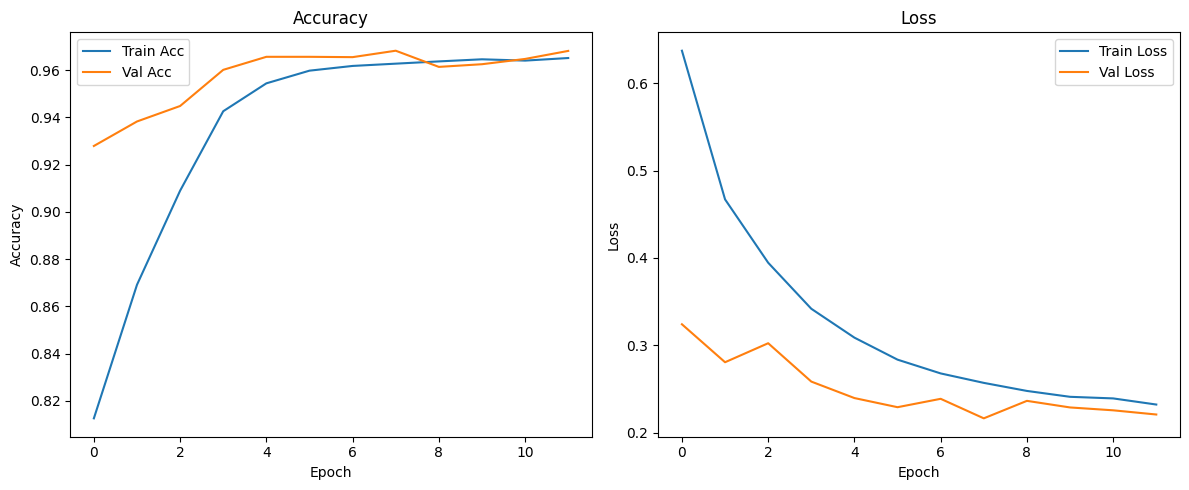

9208/9208 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
5161/5161 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


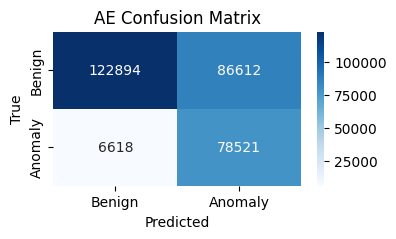


AE Metrics:
True Positives (Anomalies correctly detected): 78521
True Negatives (Normal Traffic correctly identified): 122894
False Positives (Normal Traffic misclassified as Anomaly): 86612
False Negatives (Anomalies missed): 6618

Accuracy: 0.6836
Precision: 0.4755
Recall: 0.9223
F1 Score: 0.6275
False Positive Rate (FPR): 0.4134
False Negative Rate (FNR): 0.0777
Total number of Bots samples classified as malicious by AE: 304
Total number of Bots samples classified as benign by AE: 85


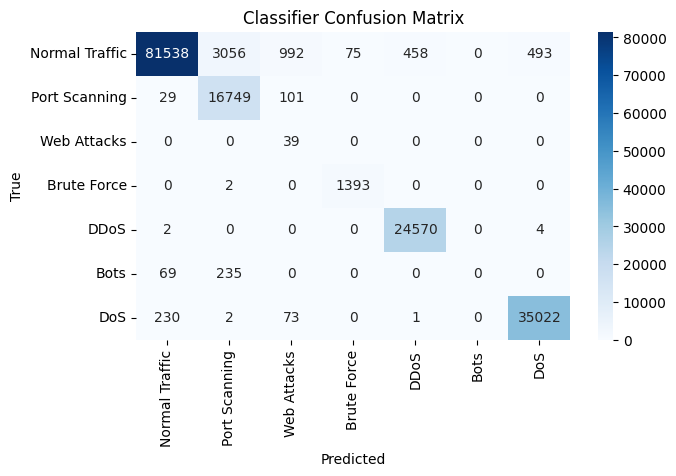

Total Malware Samples: 78521
Total Benign Samples: 86612

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 78191 (99.58% of Malware Identified)
True Negatives (Benign predicted as Benign): 81538 (94.14% of Benign Identified)
False Positives (Benign predicted as Malware): 5074 (5.86% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 330 (0.42% of Malware Misclassified)

Percentage of each Malware Class Correctly Identified:
Port Scanning: 99.23%
Web Attacks: 100.00%
Brute Force: 99.86%
DDoS: 99.98%
Bots: 0.00%
DoS: 99.13%

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.9673
Precision (Malware): 0.9391
Recall / Sensitivity (Malware): 0.9958
F1-Score (Malware): 0.9666
False Positive Rate (Benign misclassified): 5.86%
False Negative Rate (Malware missed): 0.42%
Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 69


In [19]:
# Removing DoS
bots_encoding = 5

# --- Get filtered datasets ---
X_classifier_train_no_Bots, y_classifier_train_no_Bots, X_classifier_val_no_Bots, y_classifier_val_no_Bots = Remove_attack_type(bots_encoding)

# --- Get Autoencoder + the per feature thresholds ---
autoencoder, per_feature_thresholds = get_ae()

# --- Get the MLP ---
classifier = build_mlp()

# --- Train the MLP on the new datasets ---
classifier = train_mlp(classifier, X_classifier_train_no_Bots, y_classifier_train_no_Bots, X_classifier_val_no_Bots, y_classifier_val_no_Bots)

# --- Test the models ---
AE_y_pred, classifier_y_preds, classifier_y_test, classifier_x_test = test_models(autoencoder, per_feature_thresholds, classifier)


# --- AE Evaluation ---
evaluate_ae(AE_y_pred,bots_encoding)


# --- Classifier Evaluation ---
evaluate_classifier(classifier_y_test, classifier_y_preds, bots_encoding)


# --- MLP Float32 baseline (no quantization) ---


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Saved artifact at '/tmp/tmp3m_7ko3c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136819011276432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281616: TensorSpec(shape=(), dtype=tf.resource, name=None)
# --- MLP Weight-only quantization (float16 weights, float32 activations) ---
Saved artifact at '/tmp/tmp_yekx67h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(sh

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# --- MLP Weight-only quantization (int8 weights, float32 activations) ---
Saved artifact at '/tmp/tmptfdt1rqz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136819011276432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281616: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


# --- MLP Full 8-bit Integer Quantization ---
Saved artifact at '/tmp/tmpez0zsmjh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  136819011276432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011280656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136819011281616: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Quant Models Ready!

 --- Evaluating AE: AE Float32 Model → MLP: MLP Float32 Model ---


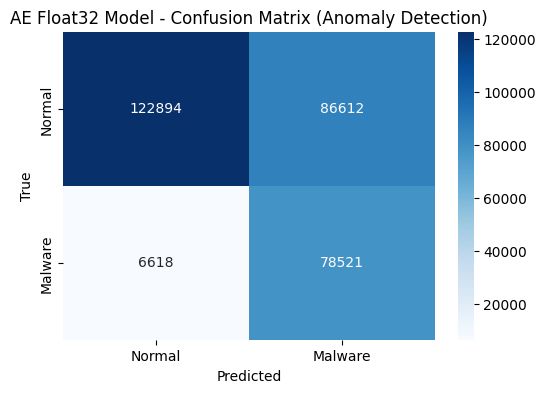


Quant AE Metrics:
True Positives (Anomalies correctly detected): 78521
True Negatives (Normal Traffic correctly identified): 122894
False Positives (Normal Traffic misclassified as Anomaly): 86612
False Negatives (Anomalies missed): 6618

Accuracy: 0.6836
Precision: 0.4755
Recall: 0.9223
F1 Score: 0.6275
False Positive Rate (FPR): 0.4134
False Negative Rate (FNR): 0.0777
Total number of Bots samples classified as malicious by AE: 304
Total number of Bots samples classified as benign by AE: 85


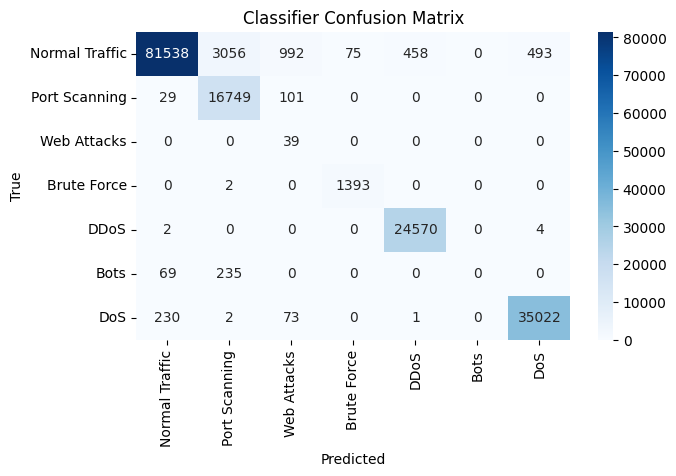

Total Malware Samples: 78521
Total Benign Samples: 86612

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 78191 (99.58% of Malware Identified)
True Negatives (Benign predicted as Benign): 81538 (94.14% of Benign Identified)
False Positives (Benign predicted as Malware): 5074 (5.86% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 330 (0.42% of Malware Misclassified)

Percentage of each Malware Class Correctly Identified:
Port Scanning: 99.23%
Web Attacks: 100.00%
Brute Force: 99.86%
DDoS: 99.98%
Bots: 0.00%
DoS: 99.13%

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.9673
Precision (Malware): 0.9391
Recall / Sensitivity (Malware): 0.9958
F1-Score (Malware): 0.9666
False Positive Rate (Benign misclassified): 5.86%
False Negative Rate (Malware missed): 0.42%
Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 69

 --- Evaluating AE: AE Float16 Wei

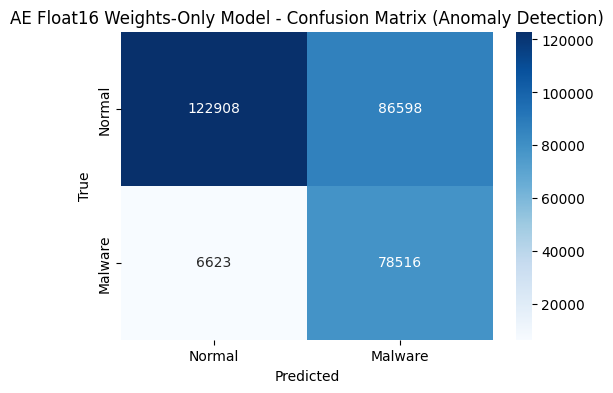


Quant AE Metrics:
True Positives (Anomalies correctly detected): 78516
True Negatives (Normal Traffic correctly identified): 122908
False Positives (Normal Traffic misclassified as Anomaly): 86598
False Negatives (Anomalies missed): 6623

Accuracy: 0.6836
Precision: 0.4755
Recall: 0.9222
F1 Score: 0.6275
False Positive Rate (FPR): 0.4133
False Negative Rate (FNR): 0.0778
Total number of Bots samples classified as malicious by AE: 304
Total number of Bots samples classified as benign by AE: 85


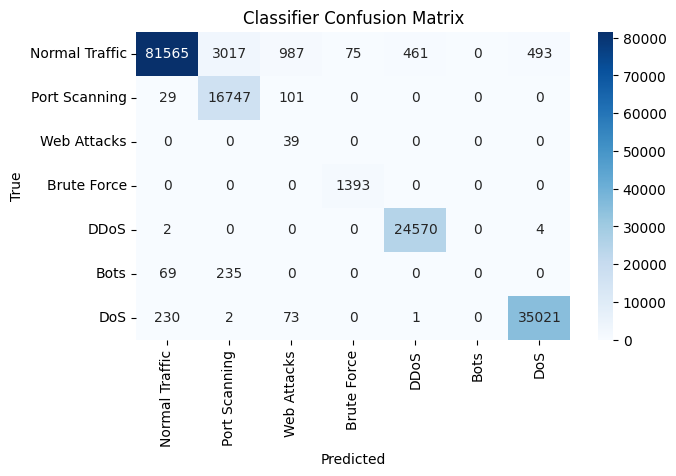

Total Malware Samples: 78516
Total Benign Samples: 86598

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 78186 (99.58% of Malware Identified)
True Negatives (Benign predicted as Benign): 81565 (94.19% of Benign Identified)
False Positives (Benign predicted as Malware): 5033 (5.81% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 330 (0.42% of Malware Misclassified)

Percentage of each Malware Class Correctly Identified:
Port Scanning: 99.23%
Web Attacks: 100.00%
Brute Force: 100.00%
DDoS: 99.98%
Bots: 0.00%
DoS: 99.13%

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.9675
Precision (Malware): 0.9395
Recall / Sensitivity (Malware): 0.9958
F1-Score (Malware): 0.9668
False Positive Rate (Benign misclassified): 5.81%
False Negative Rate (Malware missed): 0.42%
Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 69

 --- Evaluating AE: AE Int8 Weigh

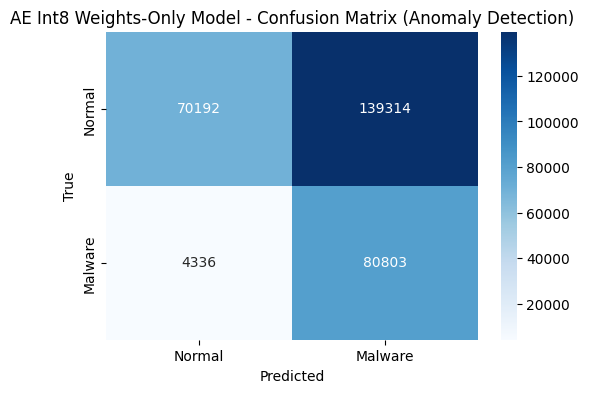


Quant AE Metrics:
True Positives (Anomalies correctly detected): 80803
True Negatives (Normal Traffic correctly identified): 70192
False Positives (Normal Traffic misclassified as Anomaly): 139314
False Negatives (Anomalies missed): 4336

Accuracy: 0.5125
Precision: 0.3671
Recall: 0.9491
F1 Score: 0.5294
False Positive Rate (FPR): 0.6650
False Negative Rate (FNR): 0.0509
Total number of Bots samples classified as malicious by AE: 371
Total number of Bots samples classified as benign by AE: 18


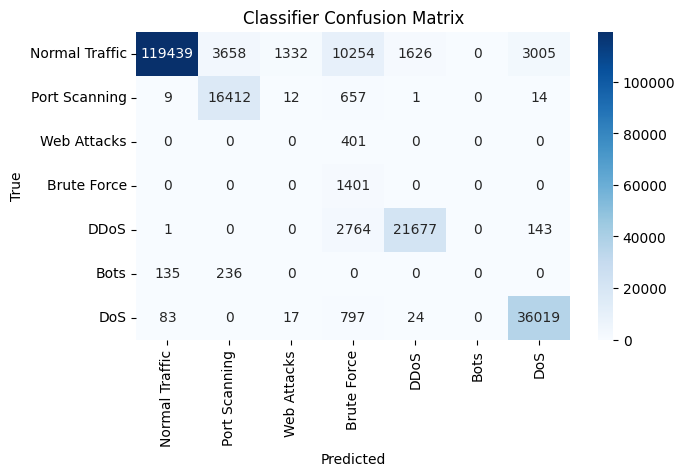

Total Malware Samples: 80803
Total Benign Samples: 139314

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 80575 (99.72% of Malware Identified)
True Negatives (Benign predicted as Benign): 119439 (85.73% of Benign Identified)
False Positives (Benign predicted as Malware): 19875 (14.27% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 228 (0.28% of Malware Misclassified)

Percentage of each Malware Class Correctly Identified:
Port Scanning: 95.95%
Web Attacks: 0.00%
Brute Force: 100.00%
DDoS: 88.17%
Bots: 0.00%
DoS: 97.51%

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.9087
Precision (Malware): 0.8021
Recall / Sensitivity (Malware): 0.9972
F1-Score (Malware): 0.8891
False Positive Rate (Benign misclassified): 14.27%
False Negative Rate (Malware missed): 0.28%
Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 135

--- Evaluating AE: AE Full In

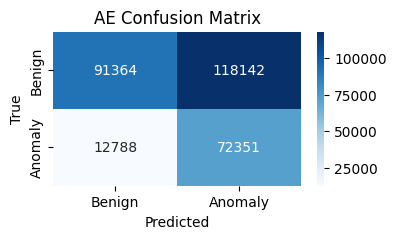


Quant AE Metrics:
True Positives (Anomalies correctly detected): 72351
True Negatives (Normal Traffic correctly identified): 91364
False Positives (Normal Traffic misclassified as Anomaly): 118142
False Negatives (Anomalies missed): 12788

Accuracy: 0.5556
Precision: 0.3798
Recall: 0.8498
F1 Score: 0.5250
False Positive Rate (FPR): 0.5639
False Negative Rate (FNR): 0.1502
Total number of Bots samples classified as malicious by AE: 324
Total number of Bots samples classified as benign by AE: 65


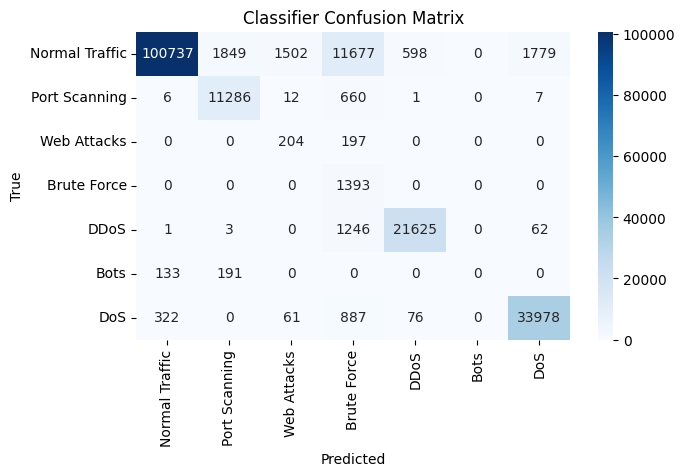

Total Malware Samples: 72351
Total Benign Samples: 118142

TP, TN, FP, FN for Malware vs Benign:
True Positives (Malware predicted as ANY malware): 71889 (99.36% of Malware Identified)
True Negatives (Benign predicted as Benign): 100737 (85.27% of Benign Identified)
False Positives (Benign predicted as Malware): 17405 (14.73% of Benign Misclassified)
False Negatives (Malware predicted as Benign): 462 (0.64% of Malware Misclassified)

Percentage of each Malware Class Correctly Identified:
Port Scanning: 94.27%
Web Attacks: 50.87%
Brute Force: 100.00%
DDoS: 94.28%
Bots: 0.00%
DoS: 96.19%

--- Malware vs Benign Performance Metrics ---
Accuracy: 0.9062
Precision (Malware): 0.8051
Recall / Sensitivity (Malware): 0.9936
F1-Score (Malware): 0.8895
False Positive Rate (Benign misclassified): 14.73%
False Negative Rate (Malware missed): 0.64%
Total number of Bots samples classified as malicious by MLP: 0
Total number of Bots samples classified as benign by MLP: 133


In [20]:
# Evaluate Quant Models
# -----------------------------------
# --- Make Quant Models -------------
# -----------------------------------
ae_quantModel_f32, ae_quantModel_int8_weights, ae_quantModel_fp16_weights, ae_quantModel_full_int8, mlp_quantModel_f32, mlp_quantModel_fp16_weights, mlp_quantModel_int8_weights, mlp_quantModel_full_int8 = quant_models(autoencoder, classifier, y_classifier_train_no_Bots, X_classifier_train_no_Bots)

# List of TFLite models (AE + MLP)
tflite_weight_models = [
    {
        "ae_model": ae_quantModel_f32,
        "ae_name": "AE Float32 Model",
        "mlp_model": mlp_quantModel_f32,
        "mlp_name": "MLP Float32 Model"
    },
    {
        "ae_model": ae_quantModel_fp16_weights,
        "ae_name": "AE Float16 Weights-Only Model",
        "mlp_model": mlp_quantModel_fp16_weights,
        "mlp_name": "MLP Float16 Weights-Only Model"
    },
    {
        "ae_model": ae_quantModel_int8_weights,
        "ae_name": "AE Int8 Weights-Only Model",
        "mlp_model": mlp_quantModel_int8_weights,
        "mlp_name": "MLP Int8 Weights-Only Model"
    }
]
# -----------------------------------
# --- evaluate_weight_quant_model ---
# -----------------------------------
evaluate_weight_quant_model(tflite_weight_models,per_feature_thresholds, bots_encoding)

tflite_full_int_models = [
    {
        "ae_model": ae_quantModel_full_int8,
        "ae_name": "AE Full Int8 Quantized Model",
        "mlp_model": mlp_quantModel_full_int8,
        "mlp_name": "MLP Full Int8 Quantized Model"
    }
]

# --------------------------------------
# --- evaluate_full_int8_quant_model ---
# --------------------------------------
evaluate_full_int8_quant_model(tflite_full_int_models,bots_encoding)
